<a href="https://colab.research.google.com/github/alekriley/alekriley.github.io/blob/master/vae_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import seaborn as sne
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

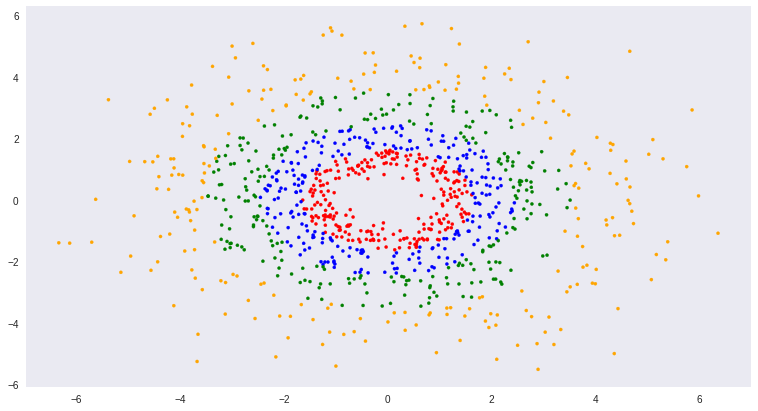

In [2]:
#2d data
n_samples = 1000
clusters = 4
theta = np.random.rand(n_samples)*2*np.pi
r = np.concatenate([np.random.rand(n_samples//clusters)*(i+1)*2//1.5+1.5 for i in range(clusters)])+\
    np.random.randn(n_samples)*0.3

data = np.array([r*np.cos(theta),r*np.sin(theta)]).T
dsort = np.argsort(data[:,0]**2+data[:,1]**2)

sne.set_style('dark')
plt.figure(figsize=(13,7))
plt.scatter(data[dsort,0],data[dsort,1],c=np.repeat(['red','blue','green','orange'],n_samples//clusters),s=10)
plt.show()

In [0]:
class VAE:
  pass

In [0]:
def declare_placeholders(self,n_features,n_clusters,hidden_layer_size):
  self.batch = tf.placeholder(tf.float32,[None,n_features])
  
VAE.__declare_placeholders = classmethod(declare_placeholders)

In [0]:
def cluster_encoder(self,n_clusters,hidden_layer_size):
  with tf.variable_scope('encoder'):
    self.ehidden = tf.layers.dense(self.batch,hidden_layer_size,tf.nn.relu,name='ehidden')
    self.ehidden2 = tf.layers.dense(self.ehidden,hidden_layer_size,tf.nn.relu,name='ehidden2')
    self.clusters = tf.layers.dense(self.ehidden2,n_clusters,tf.nn.softmax,name='clusters')
    self.clusters_for_inference = tf.expand_dims(self.clusters,0)*tf.ones([n_clusters,1,1])
  
VAE.__cluster_encoder = classmethod(cluster_encoder)

In [0]:
def latent_encoder(self,n_clusters,n_features):
  with tf.variable_scope('encoder',reuse=tf.AUTO_REUSE):
    self.c_samples = tf.placeholder(tf.float32,(None,n_clusters))
    self.latent = tf.layers.dense(tf.concat([self.clusters,self.c_samples],1),2*n_features,name='latent')
    self.one_hots = tf.expand_dims(tf.eye(n_clusters),1)*tf.ones([1,tf.shape(self.batch)[0],1])
    self.latent_for_inference = tf.layers.dense(tf.concat([self.one_hots,self.clusters_for_inference],2),2*n_features,name='latent',reuse=True)
    self.l_samples = tf.placeholder(tf.float32,(None,n_features))
    self.l_samples_for_inference = tf.random_normal([n_clusters,tf.shape(self.batch)[0],n_features])*\
                                    tf.exp(self.latent_for_inference[:,:,n_features:])+self.latent_for_inference[:,:,:n_features]
    
VAE.__latent_encoder = classmethod(latent_encoder)

In [0]:
def decoder(self,hidden_layer_size,n_features):
  with tf.variable_scope('decoder',reuse=tf.AUTO_REUSE):
    self.dhidden = tf.layers.dense(tf.concat([self.l_samples,self.c_samples],1),hidden_layer_size,tf.nn.relu,name='dhidden')
    self.dhidden_for_inference = tf.layers.dense(tf.concat([self.one_hots,self.l_samples_for_inference],2),
                                                 hidden_layer_size,tf.nn.relu,name='dhidden',reuse=True)
    self.dhidden2 = tf.layers.dense(self.dhidden,hidden_layer_size,tf.nn.relu,name='dhidden2')
    self.dhidden2_for_inference = tf.layers.dense(self.dhidden_for_inference,hidden_layer_size,
                                                  tf.nn.relu,name='dhidden2',reuse=True)
    self.reconstruction = tf.layers.dense(self.dhidden2,n_features,name='reconstruction')
    self.reconstruction_for_inference = tf.layers.dense(self.dhidden2_for_inference,n_features,name='reconstruction',reuse=True)

VAE.__decoder = classmethod(decoder)

In [0]:
def losses(self,n_features,n_clusters):
  with tf.variable_scope('losses'):
    self.categorical_kl = tf.reduce_sum(self.clusters*tf.log(n_clusters*self.clusters),1)
    self.kl_mixture = 

In [0]:
def init(self,n_features,n_clusters,hidden_layer_size):
  self.__declare_placeholders(n_features,n_clusters,hidden_layer_size)
  self.__cluster_encoder(n_clusters,hidden_layer_size)
  self.__latent_encoder(n_clusters,n_features)
  self.__decoder(hidden_layer_size,n_features)
 
VAE.__init__ = classmethod(init)
  

In [0]:
tf.reset_default_graph()
vae = VAE(2,4,10)

sess = tf.Session()


In [95]:
tf.trainable_variables()

[<tf.Variable 'encoder/ehidden/kernel:0' shape=(2, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/ehidden/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/ehidden2/kernel:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/ehidden2/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/clusters/kernel:0' shape=(10, 4) dtype=float32_ref>,
 <tf.Variable 'encoder/clusters/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'encoder/latent/kernel:0' shape=(8, 4) dtype=float32_ref>,
 <tf.Variable 'encoder/latent/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'decoder/dhidden/kernel:0' shape=(6, 10) dtype=float32_ref>,
 <tf.Variable 'decoder/dhidden/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'decoder/dhidden2/kernel:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'decoder/dhidden2/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'decoder/reconstruction/kernel:0' shape=(10, 2) dtype=float32_ref>,
 <tf.Variable 'decoder/reconstruction/b